# Method 7 - Best Ideas Low Popularity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter Popularity

best_ideas['port_tilt_pct'] = best_ideas.groupby('datadate')['adj_target'].rank(pct=True)

popularity = best_ideas.groupby(['datadate', 'fsym_id'])['port_tilt_pct'].sum().reset_index()
popularity['median_port_tilt_pct'] = popularity.groupby('datadate')['port_tilt_pct'].transform('median')
popularity = popularity[popularity['port_tilt_pct'] < popularity['median_port_tilt_pct']]

best_ideas = best_ideas.merge(popularity[['datadate', 'fsym_id', 'median_port_tilt_pct']])

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

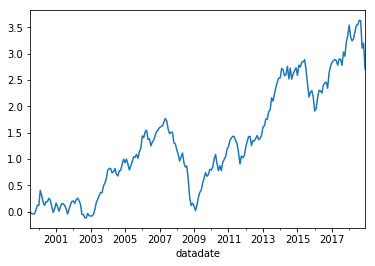

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.123830
2000-12-31   -0.059248
2001-12-31    0.132477
2002-12-31   -0.228094
2003-12-31    0.768079
2004-12-31    0.222996
2005-12-31    0.103659
2006-12-31    0.156411
2007-12-31   -0.102484
2008-12-31   -0.491145
2009-12-31    0.549234
2010-12-31    0.213360
2011-12-31   -0.057791
2012-12-31    0.186045
2013-12-31    0.446386
2014-12-31    0.054873
2015-12-31   -0.150271
2016-12-31    0.183465
2017-12-31    0.156196
2018-12-31   -0.146100
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     472.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.61e-109
Time:                        21:42:40   Log-Likelihood:                 599.22
No. Observations:                 234   AIC:                            -1188.
Df Residuals:                     229   BIC:                            -1171.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.521      0.130      -0.001       0.004
mktrf          0.8629      0.035     24.489      0.000       0.793       0.932
me             0.6840      0.041     16.688      0.000       0.603       0.765
ia             0.0424      0.062      0.680      0.497      -0.080       0.165
roe           -0.2544      0.053     -4.771      0.000      -0.359      -0.149
==============================================================================
Omnibus:                       16.760   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.594
Skew:                          -0.343   Prob(JB):                     5.07e-08
Kurtosis:                       4.725   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     417.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.40e-104
Time:                        21:42:40   Log-Likelihood:                 599.22
No. Observations:                 234   AIC:                            -1188.
Df Residuals:                     229   BIC:                            -1171.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.470      0.142      -0.001       0.005
mktrf          0.8629      0.040     21.617      0.000       0.785       0.941
me             0.6840      0.068     10.033      0.000       0.550       0.818
ia             0.0424      0.071      0.598      0.550      -0.097       0.181
roe           -0.2544      0.054     -4.744      0.000      -0.360      -0.149
==============================================================================
Omnibus:                       16.760   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.594
Skew:                          -0.343   Prob(JB):                     5.07e-08
Kurtosis:                       4.725   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     559.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.56e-117
Time:                        21:42:40   Log-Likelihood:                 599.22
No. Observations:                 234   AIC:                            -1188.
Df Residuals:                     229   BIC:                            -1171.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.475      0.140      -0.001       0.005
mktrf          0.8629      0.039     22.165      0.000       0.787       0.939
me             0.6840      0.070      9.818      0.000       0.547       0.821
ia             0.0424      0.067      0.633      0.527      -0.089       0.173
roe           -0.2544      0.050     -5.070      0.000      -0.353      -0.156
==============================================================================
Omnibus:                       16.760   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.594
Skew:                          -0.343   Prob(JB):                     5.07e-08
Kurtosis:                       4.725   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     343.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.88e-104
Time:                        21:42:40   Log-Likelihood:                 589.98
No. Observations:                 234   AIC:                            -1168.
Df Residuals:                     228   BIC:                            -1147.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.262      0.208      -0.001       0.004
mktrf          0.9004      0.037     24.460      0.000       0.828       0.973
smb            0.7038      0.049     14.490      0.000       0.608       0.799
hml            0.0542      0.057      0.946      0.345      -0.059       0.167
rmw           -0.2313      0.065     -3.572      0.000      -0.359      -0.104
cma            0.1156      0.082      1.404      0.162      -0.047       0.278
==============================================================================
Omnibus:                       13.318   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               30.076
Skew:                          -0.172   Prob(JB):                     2.95e-07
Kurtosis:                       4.722   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     482.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.99e-119
Time:                        21:42:40   Log-Likelihood:                 589.98
No. Observations:                 234   AIC:                            -1168.
Df Residuals:                     228   BIC:                            -1147.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      1.020      0.308      -0.002       0.005
mktrf          0.9004      0.054     16.522      0.000       0.794       1.007
smb            0.7038      0.058     12.056      0.000       0.589       0.818
hml            0.0542      0.110      0.492      0.622      -0.161       0.270
rmw           -0.2313      0.071     -3.280      0.001      -0.370      -0.093
cma            0.1156      0.098      1.184      0.237      -0.076       0.307
==============================================================================
Omnibus:                       13.318   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               30.076
Skew:                          -0.172   Prob(JB):                     2.95e-07
Kurtosis:                       4.722   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     624.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.43e-131
Time:                        21:42:40   Log-Likelihood:                 589.98
No. Observations:                 234   AIC:                            -1168.
Df Residuals:                     228   BIC:                            -1147.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      1.005      0.315      -0.002       0.005
mktrf          0.9004      0.056     16.207      0.000       0.792       1.009
smb            0.7038      0.059     11.907      0.000       0.588       0.820
hml            0.0542      0.113      0.481      0.631      -0.167       0.275
rmw           -0.2313      0.071     -3.281      0.001      -0.369      -0.093
cma            0.1156      0.097      1.190      0.234      -0.075       0.306
==============================================================================
Omnibus:                       13.318   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               30.076
Skew:                          -0.172   Prob(JB):                     2.95e-07
Kurtosis:                       4.722   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     409.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.93e-103
Time:                        21:42:40   Log-Likelihood:                 584.44
No. Observations:                 234   AIC:                            -1159.
Df Residuals:                     229   BIC:                            -1142.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.838      0.403      -0.002       0.004
mktrf          0.9245      0.035     26.751      0.000       0.856       0.993
smb            0.7793      0.043     18.065      0.000       0.694       0.864
hml            0.1663      0.043      3.881      0.000       0.082       0.251
umd           -0.0482      0.028     -1.714      0.088      -0.104       0.007
==============================================================================
Omnibus:                       17.494   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.864
Skew:                          -0.201   Prob(JB):                     2.45e-11
Kurtosis:                       5.202   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     457.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.82e-108
Time:                        21:42:40   Log-Likelihood:                 584.44
No. Observations:                 234   AIC:                            -1159.
Df Residuals:                     229   BIC:                            -1142.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.773      0.440      -0.002       0.004
mktrf          0.9245      0.040     22.959      0.000       0.846       1.003
smb            0.7793      0.068     11.392      0.000       0.645       0.913
hml            0.1663      0.073      2.265      0.023       0.022       0.310
umd           -0.0482      0.026     -1.852      0.064      -0.099       0.003
==============================================================================
Omnibus:                       17.494   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.864
Skew:                          -0.201   Prob(JB):                     2.45e-11
Kurtosis:                       5.202   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     437.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.35e-106
Time:                        21:42:40   Log-Likelihood:                 584.44
No. Observations:                 234   AIC:                            -1159.
Df Residuals:                     229   BIC:                            -1142.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.811      0.417      -0.002       0.004
mktrf          0.9245      0.038     24.131      0.000       0.849       1.000
smb            0.7793      0.068     11.517      0.000       0.647       0.912
hml            0.1663      0.081      2.055      0.040       0.008       0.325
umd           -0.0482      0.024     -2.037      0.042      -0.095      -0.002
==============================================================================
Omnibus:                       17.494   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.864
Skew:                          -0.201   Prob(JB):                     2.45e-11
Kurtosis:                       5.202   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     240.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.87e-55
Time:                        21:42:40   Log-Likelihood:                 290.19
No. Observations:                 120   AIC:                            -570.4
Df Residuals:                     115   BIC:                            -556.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.231      0.221      -0.002       0.007
mktrf          0.8870      0.057     15.629      0.000       0.775       0.999
me             0.7374      0.056     13.155      0.000       0.626       0.848
ia            -0.0305      0.088     -0.347      0.729      -0.204       0.143
roe           -0.1875      0.078     -2.414      0.017      -0.341      -0.034
==============================================================================
Omnibus:                       13.704   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.518
Skew:                          -0.637   Prob(JB):                     0.000157
Kurtosis:                       4.371   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     276.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.89e-58
Time:                        21:42:40   Log-Likelihood:                 290.19
No. Observations:                 120   AIC:                            -570.4
Df Residuals:                     115   BIC:                            -556.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.125      0.261      -0.002       0.007
mktrf          0.8870      0.052     17.180      0.000       0.786       0.988
me             0.7374      0.072     10.295      0.000       0.597       0.878
ia            -0.0305      0.094     -0.325      0.745      -0.214       0.153
roe           -0.1875      0.063     -2.960      0.003      -0.312      -0.063
==============================================================================
Omnibus:                       13.704   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.518
Skew:                          -0.637   Prob(JB):                     0.000157
Kurtosis:                       4.371   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     385.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.39e-65
Time:                        21:42:40   Log-Likelihood:                 290.19
No. Observations:                 120   AIC:                            -570.4
Df Residuals:                     115   BIC:                            -556.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.114      0.265      -0.002       0.007
mktrf          0.8870      0.044     19.967      0.000       0.800       0.974
me             0.7374      0.071     10.361      0.000       0.598       0.877
ia            -0.0305      0.089     -0.342      0.732      -0.205       0.144
roe           -0.1875      0.057     -3.313      0.001      -0.298      -0.077
==============================================================================
Omnibus:                       13.704   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.518
Skew:                          -0.637   Prob(JB):                     0.000157
Kurtosis:                       4.371   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     171.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.58e-51
Time:                        21:42:40   Log-Likelihood:                 284.60
No. Observations:                 120   AIC:                            -557.2
Df Residuals:                     114   BIC:                            -540.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.002      1.522      0.131      -0.001       0.008
mktrf          0.9232      0.063     14.661      0.000       0.798       1.048
smb            0.7579      0.071     10.626      0.000       0.617       0.899
hml            0.0550      0.087      0.630      0.530      -0.118       0.228
rmw           -0.2166      0.103     -2.102      0.038      -0.421      -0.012
cma            0.1000      0.113      0.886      0.377      -0.124       0.324
==============================================================================
Omnibus:                       10.972   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               14.133
Skew:                          -0.510   Prob(JB):                     0.000853
Kurtosis:                       4.336   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     323.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.43e-65
Time:                        21:42:40   Log-Likelihood:                 284.60
No. Observations:                 120   AIC:                            -557.2
Df Residuals:                     114   BIC:                            -540.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.003      1.279      0.201      -0.002       0.009
mktrf          0.9232      0.091     10.157      0.000       0.745       1.101
smb            0.7579      0.073     10.346      0.000       0.614       0.901
hml            0.0550      0.194      0.284      0.777      -0.325       0.435
rmw           -0.2166      0.136     -1.592      0.111      -0.483       0.050
cma            0.1000      0.134      0.744      0.457      -0.163       0.363
==============================================================================
Omnibus:                       10.972   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               14.133
Skew:                          -0.510   Prob(JB):                     0.000853
Kurtosis:                       4.336   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     536.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.96e-77
Time:                        21:42:40   Log-Likelihood:                 284.60
No. Observations:                 120   AIC:                            -557.2
Df Residuals:                     114   BIC:                            -540.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.003      1.310      0.190      -0.002       0.009
mktrf          0.9232      0.087     10.665      0.000       0.754       1.093
smb            0.7579      0.069     10.954      0.000       0.622       0.893
hml            0.0550      0.202      0.272      0.785      -0.341       0.451
rmw           -0.2166      0.139     -1.562      0.118      -0.488       0.055
cma            0.1000      0.132      0.757      0.449      -0.159       0.359
==============================================================================
Omnibus:                       10.972   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               14.133
Skew:                          -0.510   Prob(JB):                     0.000853
Kurtosis:                       4.336   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     202.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.53e-51
Time:                        21:42:40   Log-Likelihood:                 281.13
No. Observations:                 120   AIC:                            -552.3
Df Residuals:                     115   BIC:                            -538.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.150      0.253      -0.002       0.007
mktrf          0.9741      0.054     18.068      0.000       0.867       1.081
smb            0.8166      0.061     13.302      0.000       0.695       0.938
hml            0.1856      0.061      3.019      0.003       0.064       0.307
umd           -0.0167      0.038     -0.440      0.661      -0.092       0.058
==============================================================================
Omnibus:                       13.796   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.107
Skew:                          -0.555   Prob(JB):                     2.61e-05
Kurtosis:                       4.729   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     352.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.44e-63
Time:                        21:42:40   Log-Likelihood:                 281.13
No. Observations:                 120   AIC:                            -552.3
Df Residuals:                     115   BIC:                            -538.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.106      0.269      -0.002       0.007
mktrf          0.9741      0.059     16.424      0.000       0.858       1.090
smb            0.8166      0.084      9.700      0.000       0.652       0.982
hml            0.1856      0.115      1.610      0.107      -0.040       0.412
umd           -0.0167      0.036     -0.466      0.642      -0.087       0.053
==============================================================================
Omnibus:                       13.796   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.107
Skew:                          -0.555   Prob(JB):                     2.61e-05
Kurtosis:                       4.729   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     382.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.10e-65
Time:                        21:42:40   Log-Likelihood:                 281.13
No. Observations:                 120   AIC:                            -552.3
Df Residuals:                     115   BIC:                            -538.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.243      0.214      -0.001       0.007
mktrf          0.9741      0.051     19.017      0.000       0.874       1.075
smb            0.8166      0.083      9.852      0.000       0.654       0.979
hml            0.1856      0.124      1.503      0.133      -0.056       0.428
umd           -0.0167      0.030     -0.563      0.573      -0.075       0.041
==============================================================================
Omnibus:                       13.796   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.107
Skew:                          -0.555   Prob(JB):                     2.61e-05
Kurtosis:                       4.729   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     253.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.17e-54
Time:                        21:42:40   Log-Likelihood:                 324.12
No. Observations:                 114   AIC:                            -638.2
Df Residuals:                     109   BIC:                            -624.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.614      0.540      -0.002       0.004
mktrf          0.8818      0.042     20.812      0.000       0.798       0.966
me             0.5105      0.065      7.803      0.000       0.381       0.640
ia             0.2128      0.091      2.345      0.021       0.033       0.393
roe           -0.3524      0.080     -4.420      0.000      -0.510      -0.194
==============================================================================
Omnibus:                        1.462   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.481   Jarque-Bera (JB):                0.963
Skew:                           0.132   Prob(JB):                        0.618
Kurtosis:                       3.365   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     337.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.09e-60
Time:                        21:42:40   Log-Likelihood:                 324.12
No. Observations:                 114   AIC:                            -638.2
Df Residuals:                     109   BIC:                            -624.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.735      0.462      -0.001       0.003
mktrf          0.8818      0.050     17.589      0.000       0.784       0.980
me             0.5105      0.062      8.227      0.000       0.389       0.632
ia             0.2128      0.093      2.282      0.022       0.030       0.396
roe           -0.3524      0.076     -4.666      0.000      -0.501      -0.204
==============================================================================
Omnibus:                        1.462   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.481   Jarque-Bera (JB):                0.963
Skew:                           0.132   Prob(JB):                        0.618
Kurtosis:                       3.365   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     305.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.86e-58
Time:                        21:42:40   Log-Likelihood:                 324.12
No. Observations:                 114   AIC:                            -638.2
Df Residuals:                     109   BIC:                            -624.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.805      0.421      -0.001       0.003
mktrf          0.8818      0.054     16.336      0.000       0.776       0.988
me             0.5105      0.054      9.447      0.000       0.405       0.616
ia             0.2128      0.093      2.294      0.022       0.031       0.395
roe           -0.3524      0.079     -4.462      0.000      -0.507      -0.198
==============================================================================
Omnibus:                        1.462   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.481   Jarque-Bera (JB):                0.963
Skew:                           0.132   Prob(JB):                        0.618
Kurtosis:                       3.365   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     190.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.64e-52
Time:                        21:42:40   Log-Likelihood:                 321.46
No. Observations:                 114   AIC:                            -630.9
Df Residuals:                     108   BIC:                            -614.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.477      0.634      -0.004       0.002
mktrf          0.9175      0.042     22.079      0.000       0.835       1.000
smb            0.5612      0.067      8.319      0.000       0.427       0.695
hml            0.1021      0.086      1.186      0.238      -0.068       0.273
rmw           -0.1172      0.105     -1.112      0.268      -0.326       0.092
cma            0.1491      0.134      1.115      0.267      -0.116       0.414
==============================================================================
Omnibus:                        1.051   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.591   Jarque-Bera (JB):                0.597
Skew:                           0.096   Prob(JB):                        0.742
Kurtosis:                       3.298   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     251.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.29e-58
Time:                        21:42:40   Log-Likelihood:                 321.46
No. Observations:                 114   AIC:                            -630.9
Df Residuals:                     108   BIC:                            -614.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.501      0.617      -0.003       0.002
mktrf          0.9175      0.047     19.476      0.000       0.825       1.010
smb            0.5612      0.057      9.832      0.000       0.449       0.673
hml            0.1021      0.072      1.424      0.154      -0.038       0.243
rmw           -0.1172      0.100     -1.173      0.241      -0.313       0.079
cma            0.1491      0.141      1.060      0.289      -0.127       0.425
==============================================================================
Omnibus:                        1.051   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.591   Jarque-Bera (JB):                0.597
Skew:                           0.096   Prob(JB):                        0.742
Kurtosis:                       3.298   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     263.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.97e-59
Time:                        21:42:40   Log-Likelihood:                 321.46
No. Observations:                 114   AIC:                            -630.9
Df Residuals:                     108   BIC:                            -614.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.483      0.629      -0.004       0.002
mktrf          0.9175      0.050     18.242      0.000       0.819       1.016
smb            0.5612      0.041     13.843      0.000       0.482       0.641
hml            0.1021      0.068      1.495      0.135      -0.032       0.236
rmw           -0.1172      0.093     -1.260      0.208      -0.300       0.065
cma            0.1491      0.142      1.048      0.295      -0.130       0.428
==============================================================================
Omnibus:                        1.051   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.591   Jarque-Bera (JB):                0.597
Skew:                           0.096   Prob(JB):                        0.742
Kurtosis:                       3.298   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     259.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.98e-55
Time:                        21:42:41   Log-Likelihood:                 325.33
No. Observations:                 114   AIC:                            -640.7
Df Residuals:                     109   BIC:                            -627.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.075      0.940      -0.003       0.003
mktrf          0.9023      0.040     22.711      0.000       0.824       0.981
smb            0.5957      0.062      9.616      0.000       0.473       0.718
hml            0.1511      0.064      2.368      0.020       0.025       0.278
umd           -0.1722      0.048     -3.578      0.001      -0.268      -0.077
==============================================================================
Omnibus:                        3.373   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.185   Jarque-Bera (JB):                3.130
Skew:                          -0.203   Prob(JB):                        0.209
Kurtosis:                       3.703   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     550.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.77e-71
Time:                        21:42:41   Log-Likelihood:                 325.33
No. Observations:                 114   AIC:                            -640.7
Df Residuals:                     109   BIC:                            -627.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.085      0.932      -0.003       0.002
mktrf          0.9023      0.041     22.173      0.000       0.823       0.982
smb            0.5957      0.063      9.457      0.000       0.472       0.719
hml            0.1511      0.052      2.921      0.003       0.050       0.252
umd           -0.1722      0.044     -3.903      0.000      -0.259      -0.086
==============================================================================
Omnibus:                        3.373   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.185   Jarque-Bera (JB):                3.130
Skew:                          -0.203   Prob(JB):                        0.209
Kurtosis:                       3.703   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     745.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.65e-78
Time:                        21:42:41   Log-Likelihood:                 325.33
No. Observations:                 114   AIC:                            -640.7
Df Residuals:                     109   BIC:                            -627.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.084      0.933      -0.003       0.002
mktrf          0.9023      0.042     21.633      0.000       0.821       0.984
smb            0.5957      0.051     11.616      0.000       0.495       0.696
hml            0.1511      0.051      2.964      0.003       0.051       0.251
umd           -0.1722      0.045     -3.851      0.000      -0.260      -0.085
==============================================================================
Omnibus:                        3.373   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.185   Jarque-Bera (JB):                3.130
Skew:                          -0.203   Prob(JB):                        0.209
Kurtosis:                       3.703   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""